SIMPLEST possible application case: don't do any fine-tuning of existing model weights; just learn a frame-level decoder. Can we do it?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers
from transformers import AutoConfig
from transformers import Wav2Vec2Model
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models.frame_level import FrameLevelRNNClassifier
from models.transformer import DataCollator

In [5]:
model_dir = "out/rnn/testrun/checkpoint-700/"
device = "cuda:0"

In [6]:
model = FrameLevelRNNClassifier.from_pretrained(model_dir).to(device)

tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
corpus_path = "timit_phoneme_corpus"

corpus = datasets.load_from_disk(corpus_path)

In [8]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    label_mask, labels = p.label_ids

    def evaluate_label(j):
        preds_j = preds[:, :, j]
        labels_j = labels[:, :, j]

        preds_j = preds_j[label_mask == 1]
        labels_j = labels_j[label_mask == 1]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

In [9]:
coll = DataCollator(processor=processor, model=model, padding=True,
                    num_labels=tokenizer.vocab_size)
training_args = TrainingArguments(
    do_train=False,
    do_eval=True,
    do_predict=True,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    use_cpu=device == "cpu",
    no_cuda=device == "cpu",
    output_dir=model_dir,
    resume_from_checkpoint=model_dir,
    label_names=["label_mask", "labels"],
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=coll,
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate

In [10]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    label_mask, labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

In [11]:
# Get optimal cut-off for each phone
optimal_thresholds = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, :, j]
    labels_j = labels[:, :, j]

    mask = label_mask == 1
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


tensor([-3.7410, -3.4003, -2.6185, -2.0119, -2.2463, -1.2385, -1.9808, -1.4398,
        -1.5219, -3.7622, -2.8102, -4.2588, -2.8970, -2.0512, -1.5934, -2.3551,
        -1.9650, -1.4176, -3.3707, -1.8607, -2.3923, -5.4938, -0.7794, -1.8846,
        -2.3840, -1.6275, -2.0400, -2.0794, -3.5076, -2.0261, -2.3966, -1.9161,
        -1.7854, -3.3677, -3.6749, -2.4345, -1.5991, -2.8235, -1.2753, -1.1233,
            inf,     inf])

In [12]:
eval_predictions = trainer.predict(corpus["test"])

In [13]:
def add_predictions(batch, idxs):
    eval_output = eval_predictions.predictions
    eval_output = eval_output[0] if isinstance(eval_output, tuple) else eval_output
    logits = eval_output[idxs]
    preds = (logits > optimal_thresholds.numpy()).astype(int)

    batch["score"] = logits
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds.numpy()
    batch["predicted"] = preds

    return batch

eval_result = corpus["test"].map(add_predictions, batched=True, batch_size=8, with_indices=True)

def compute_accuracy(item, idx):
    label_mask, labels = eval_predictions.label_ids
    label_mask = label_mask[idx] == 1
    labels = labels[idx]

    item["real_frames"] = label_mask.sum()
    item["correct"] = (np.array(item["predicted"])[label_mask] == labels[label_mask])
    item["fp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 0)
    item["fn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 1)
    item["tp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 1)
    item["tn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 0)
    item["accuracy"] = item["correct"].mean()
    return item

eval_result = eval_result.map(compute_accuracy, batched=False, with_indices=True)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [14]:
viz_columns = [None] * tokenizer.vocab_size
for token, idx in tokenizer.get_vocab().items():
    if idx < tokenizer.vocab_size:
        viz_columns[idx] = token

In [15]:
def plot_timit_items(idxs, phone_plot_key="phonemic_detail"):
    f, axs = plt.subplots(len(idxs), figsize=(20, 8 * len(idxs)))

    for idx, ax in zip(idxs, axs.ravel()):
        item = eval_result[idx]

        # compute compression ratio between input and output
        num_item_frames = item["real_frames"]
        num_input_frames = len(item["input_values"])
        compression_ratio = num_item_frames / num_input_frames

        word_detail = item["word_detail"]
        word_starts = set()
        for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
            start = start * compression_ratio
            stop = stop * compression_ratio
            word_starts.add(start)

            ax.axhline(start, color="white", linestyle="--")
            # show phone centered over its span
            ax.text(-2, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

        for i, (start, stop, phon) in enumerate(zip(item[phone_plot_key]["start"], item[phone_plot_key]["stop"], item[phone_plot_key]["utterance"])):
            start = start * compression_ratio
            stop = stop * compression_ratio

            if start not in word_starts:
                ax.axhline(start, color="white", linestyle="--", alpha=0.5)
            
            # show phone centered over its span
            ax.text(0, (start + stop) / 2, phon, ha="right", va="center", fontsize=12)

        yield ax, item

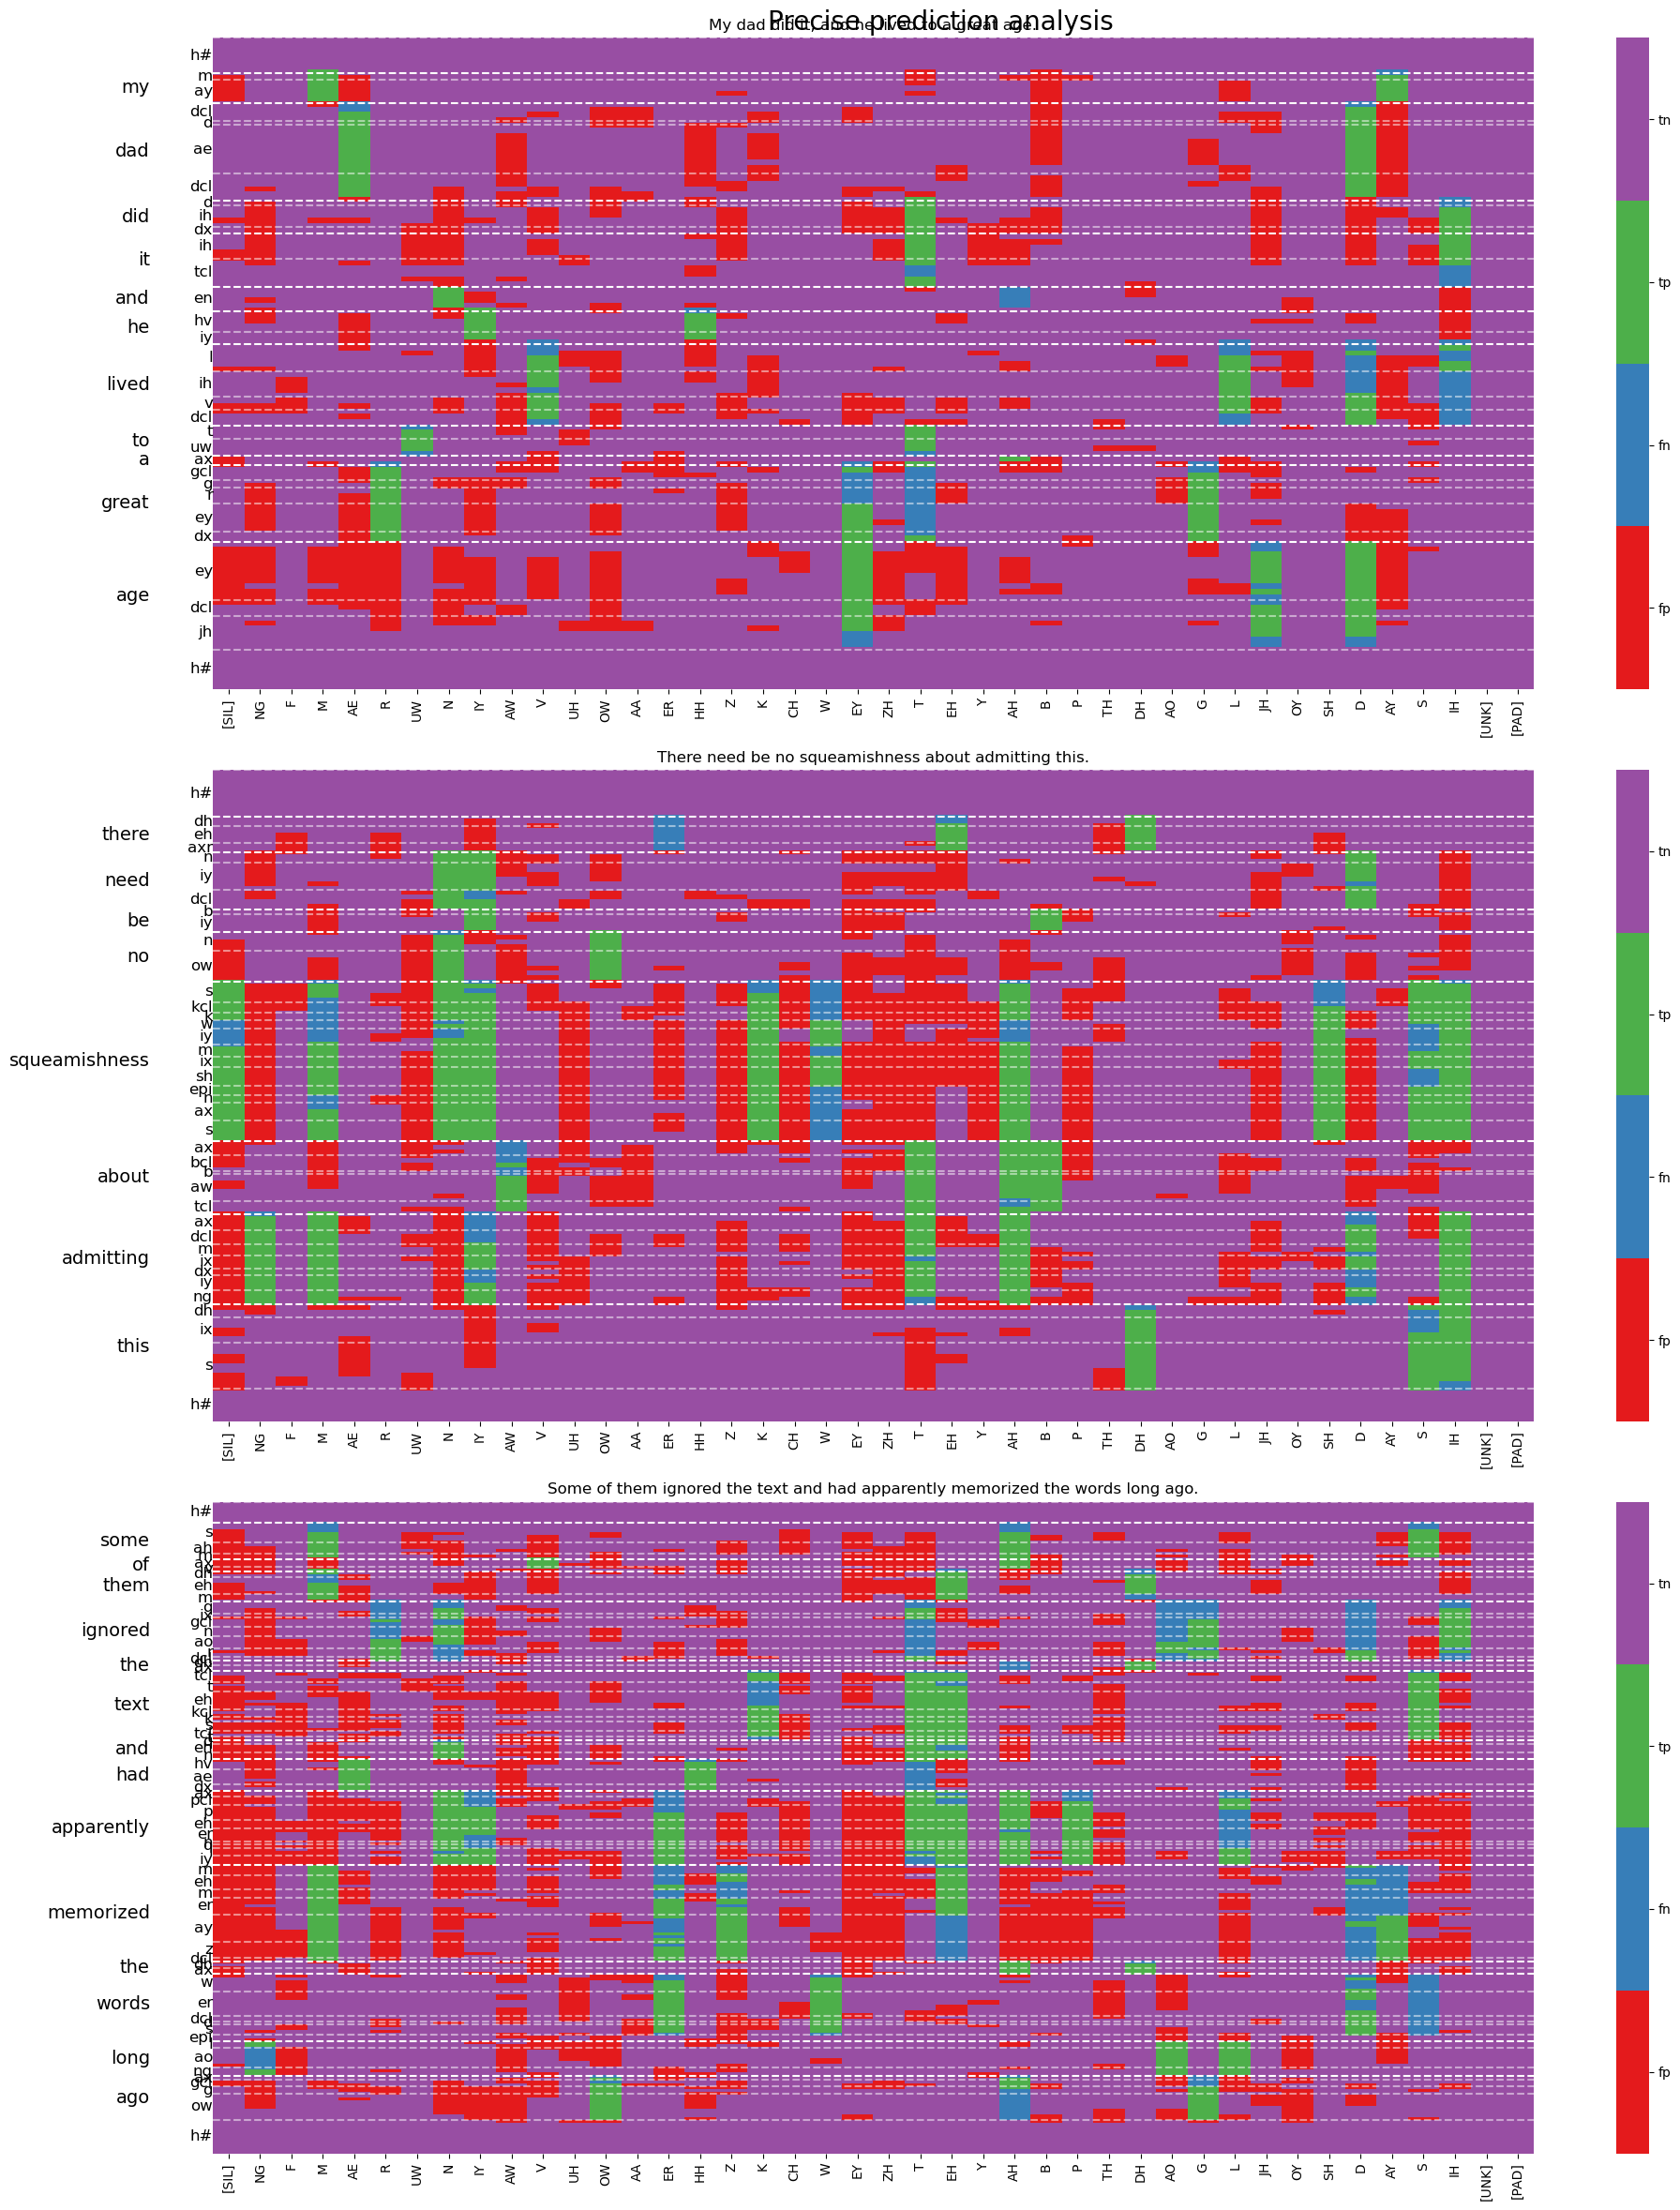

In [16]:
# viz phoneme predictions
n_to_plot = 3
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for ax, item in plot_timit_items(plot_idxs):
    data = np.zeros_like(item["correct"]).astype(int)
    data[np.array(item["fp"])] = 1
    data[np.array(item["fn"])] = 2
    data[np.array(item["tp"])] = 3
    data[np.array(item["tn"])] = 4
    color_labels = ["fp", "fn", "tp", "tn"]

    # result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    result = pd.DataFrame(data[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax, cmap=sns.color_palette("Set1", 4))
    ax.set_title(item["text"])
    ax.set_yticks([])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
    colorbar.set_ticklabels(color_labels)

ax.figure.suptitle("Precise prediction analysis", fontsize=20)
ax.figure.tight_layout()

Text(0.5, 0.98, 'Raw predictions')

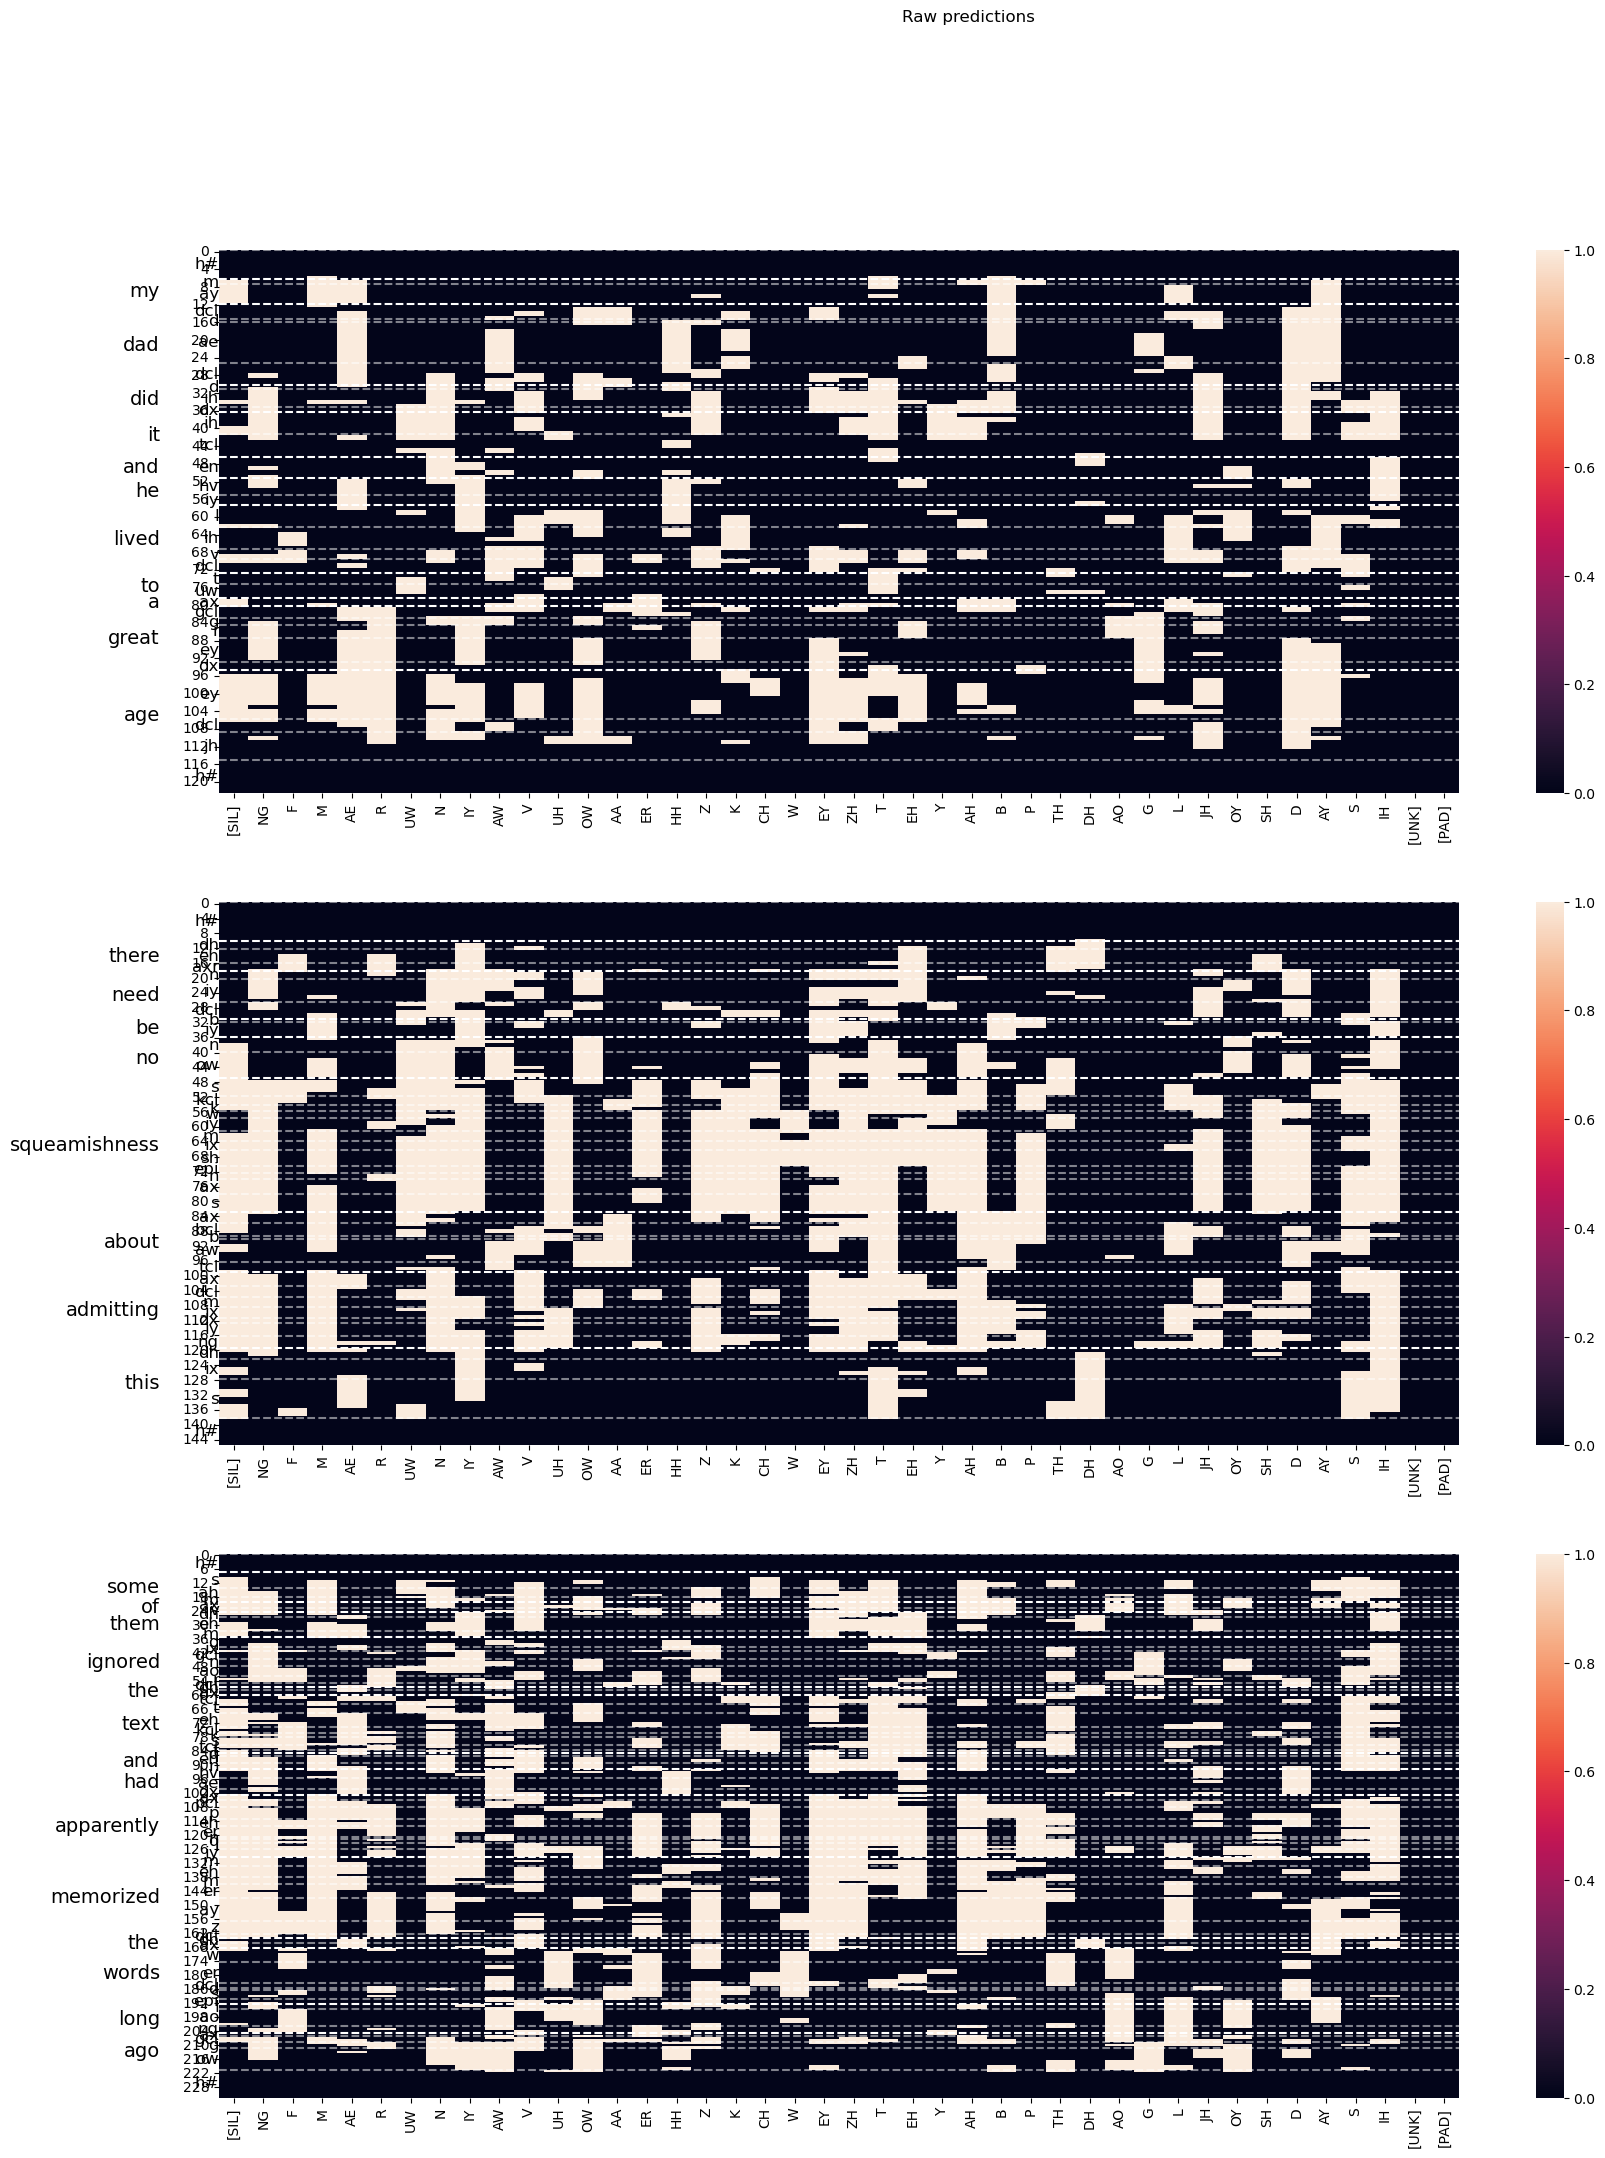

In [17]:
# viz raw predictions
for ax, item in plot_timit_items(plot_idxs):
    result = pd.DataFrame(item["predicted"][:item["real_frames"]],
                          columns=viz_columns)
    sns.heatmap(result, ax=ax)

ax.figure.suptitle("Raw predictions")

Text(0.5, 0.98, 'Ground truth')

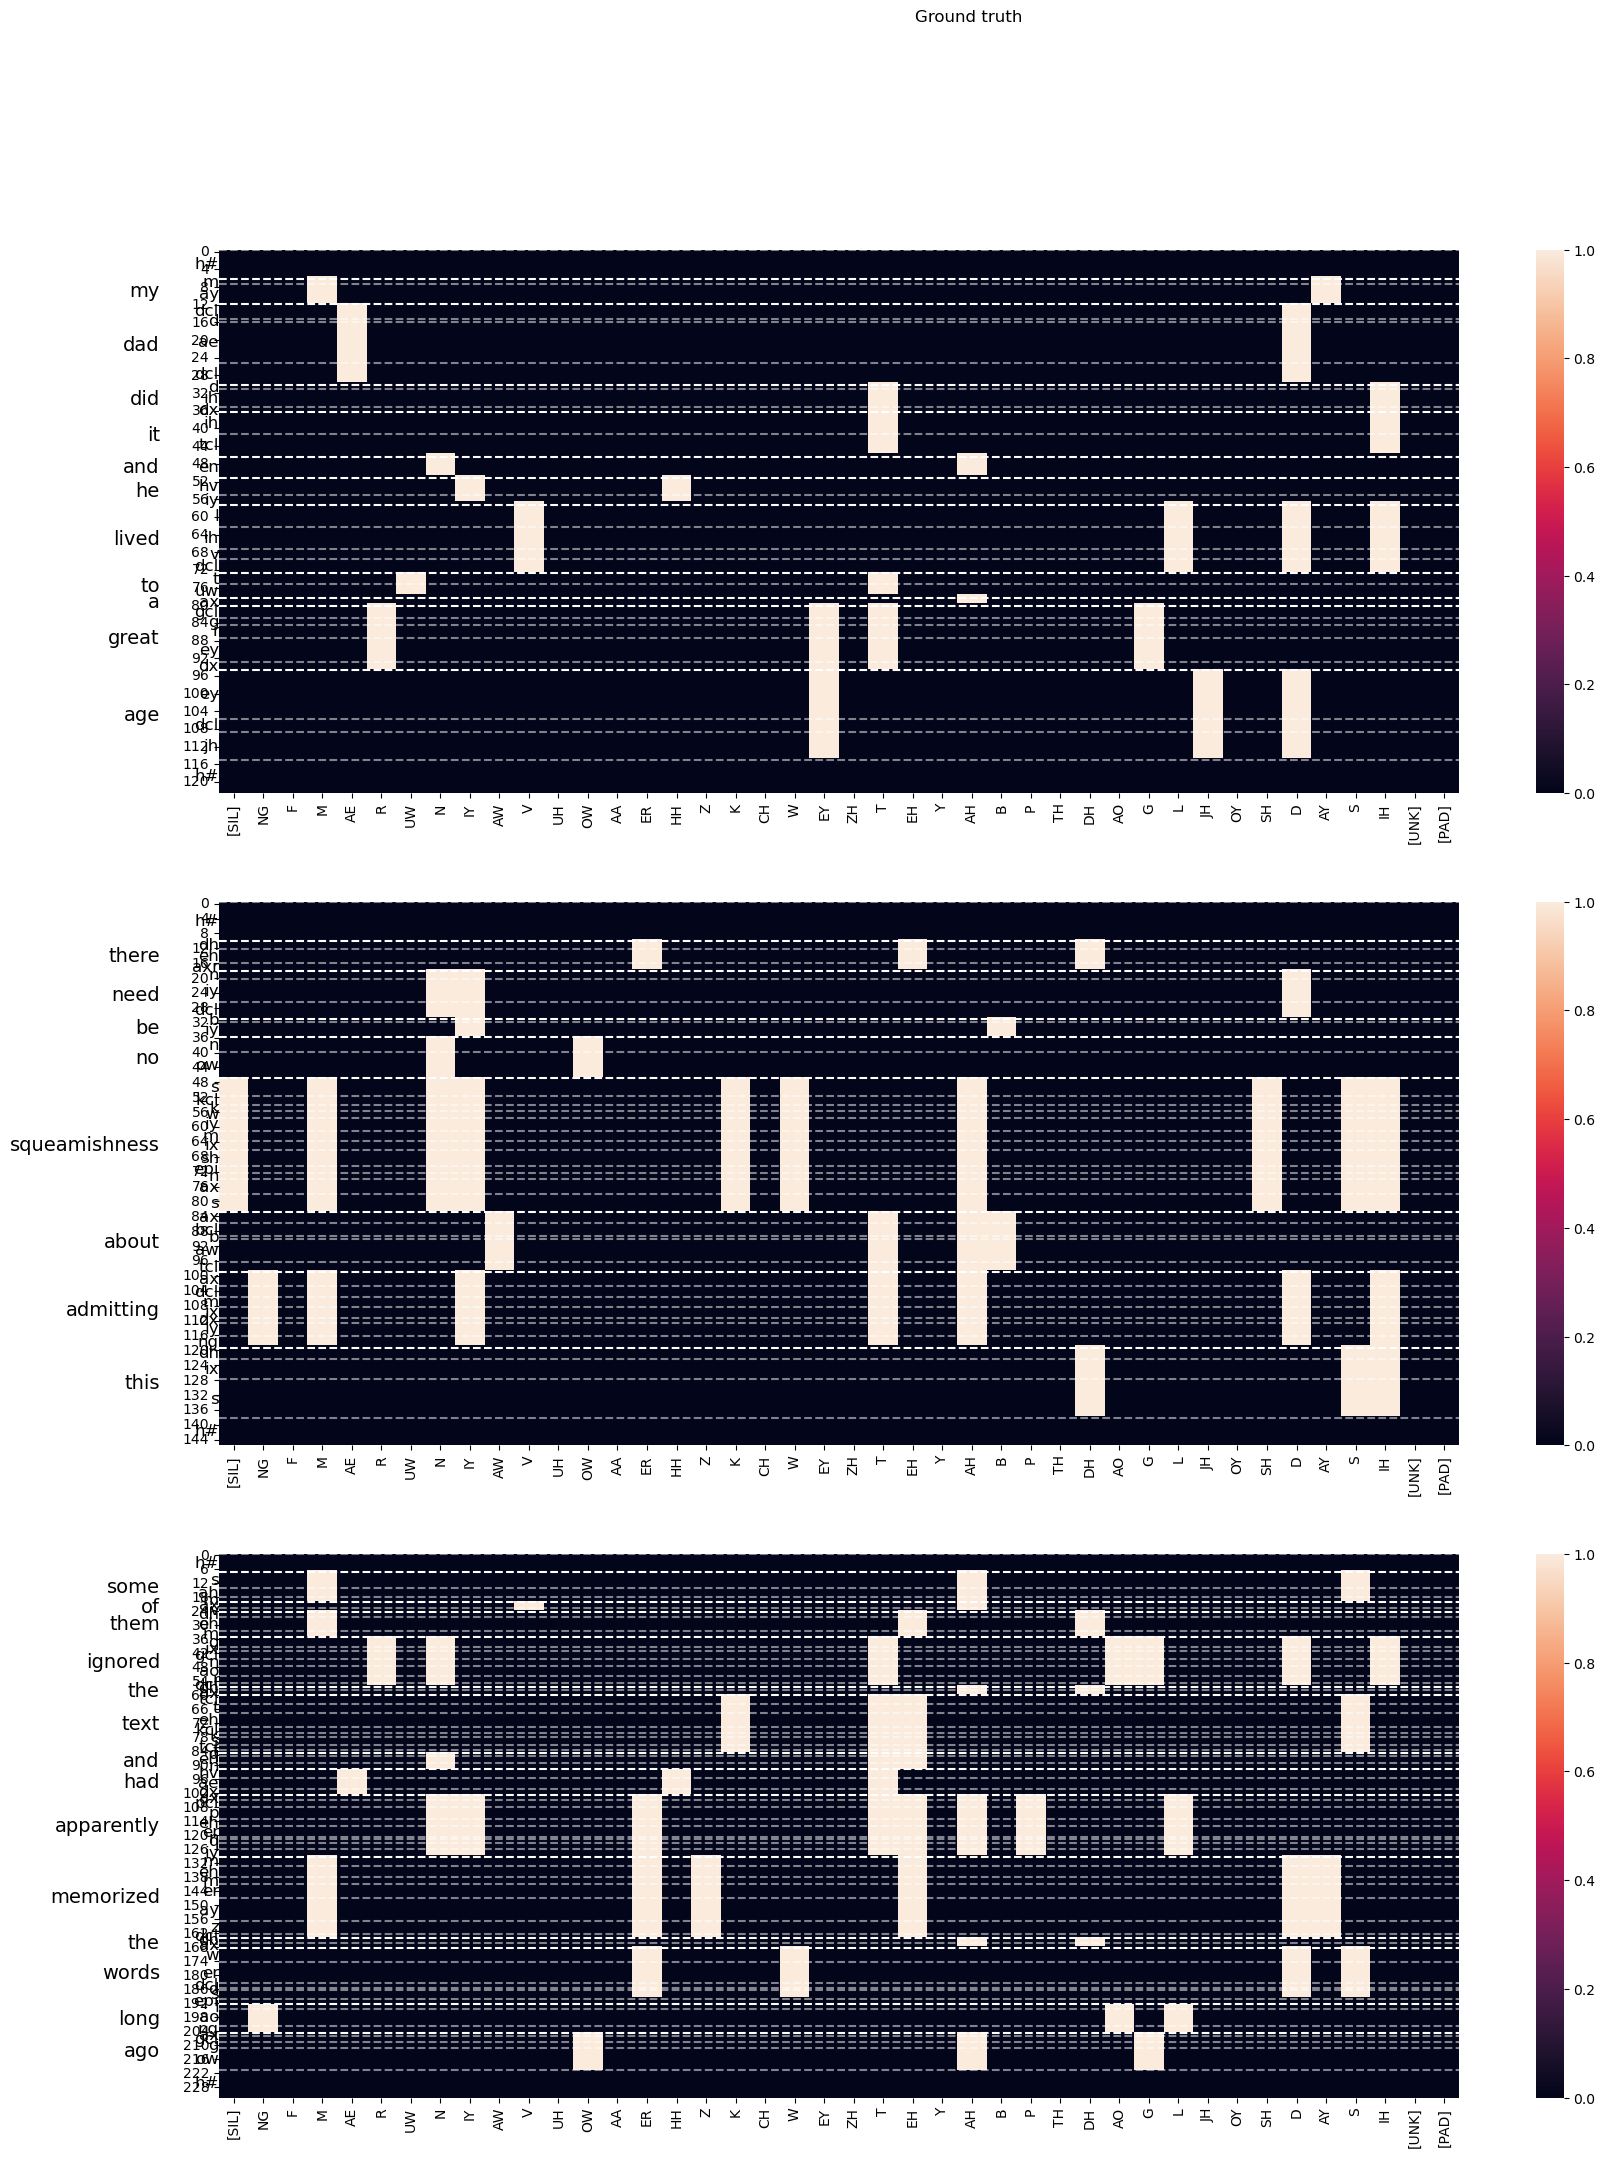

In [18]:
# viz labels
for ax, item in plot_timit_items(plot_idxs):
    compression_ratio = item["real_frames"] / len(item["input_values"])
    label_mat = np.zeros_like(item["predicted"])
    for onset, offset, idx in item["phone_targets"]:
        onset = int(onset * compression_ratio)
        offset = int(offset * compression_ratio)
        label_mat[onset:offset, idx] = 1

    result = pd.DataFrame(label_mat[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax)

ax.figure.suptitle("Ground truth")

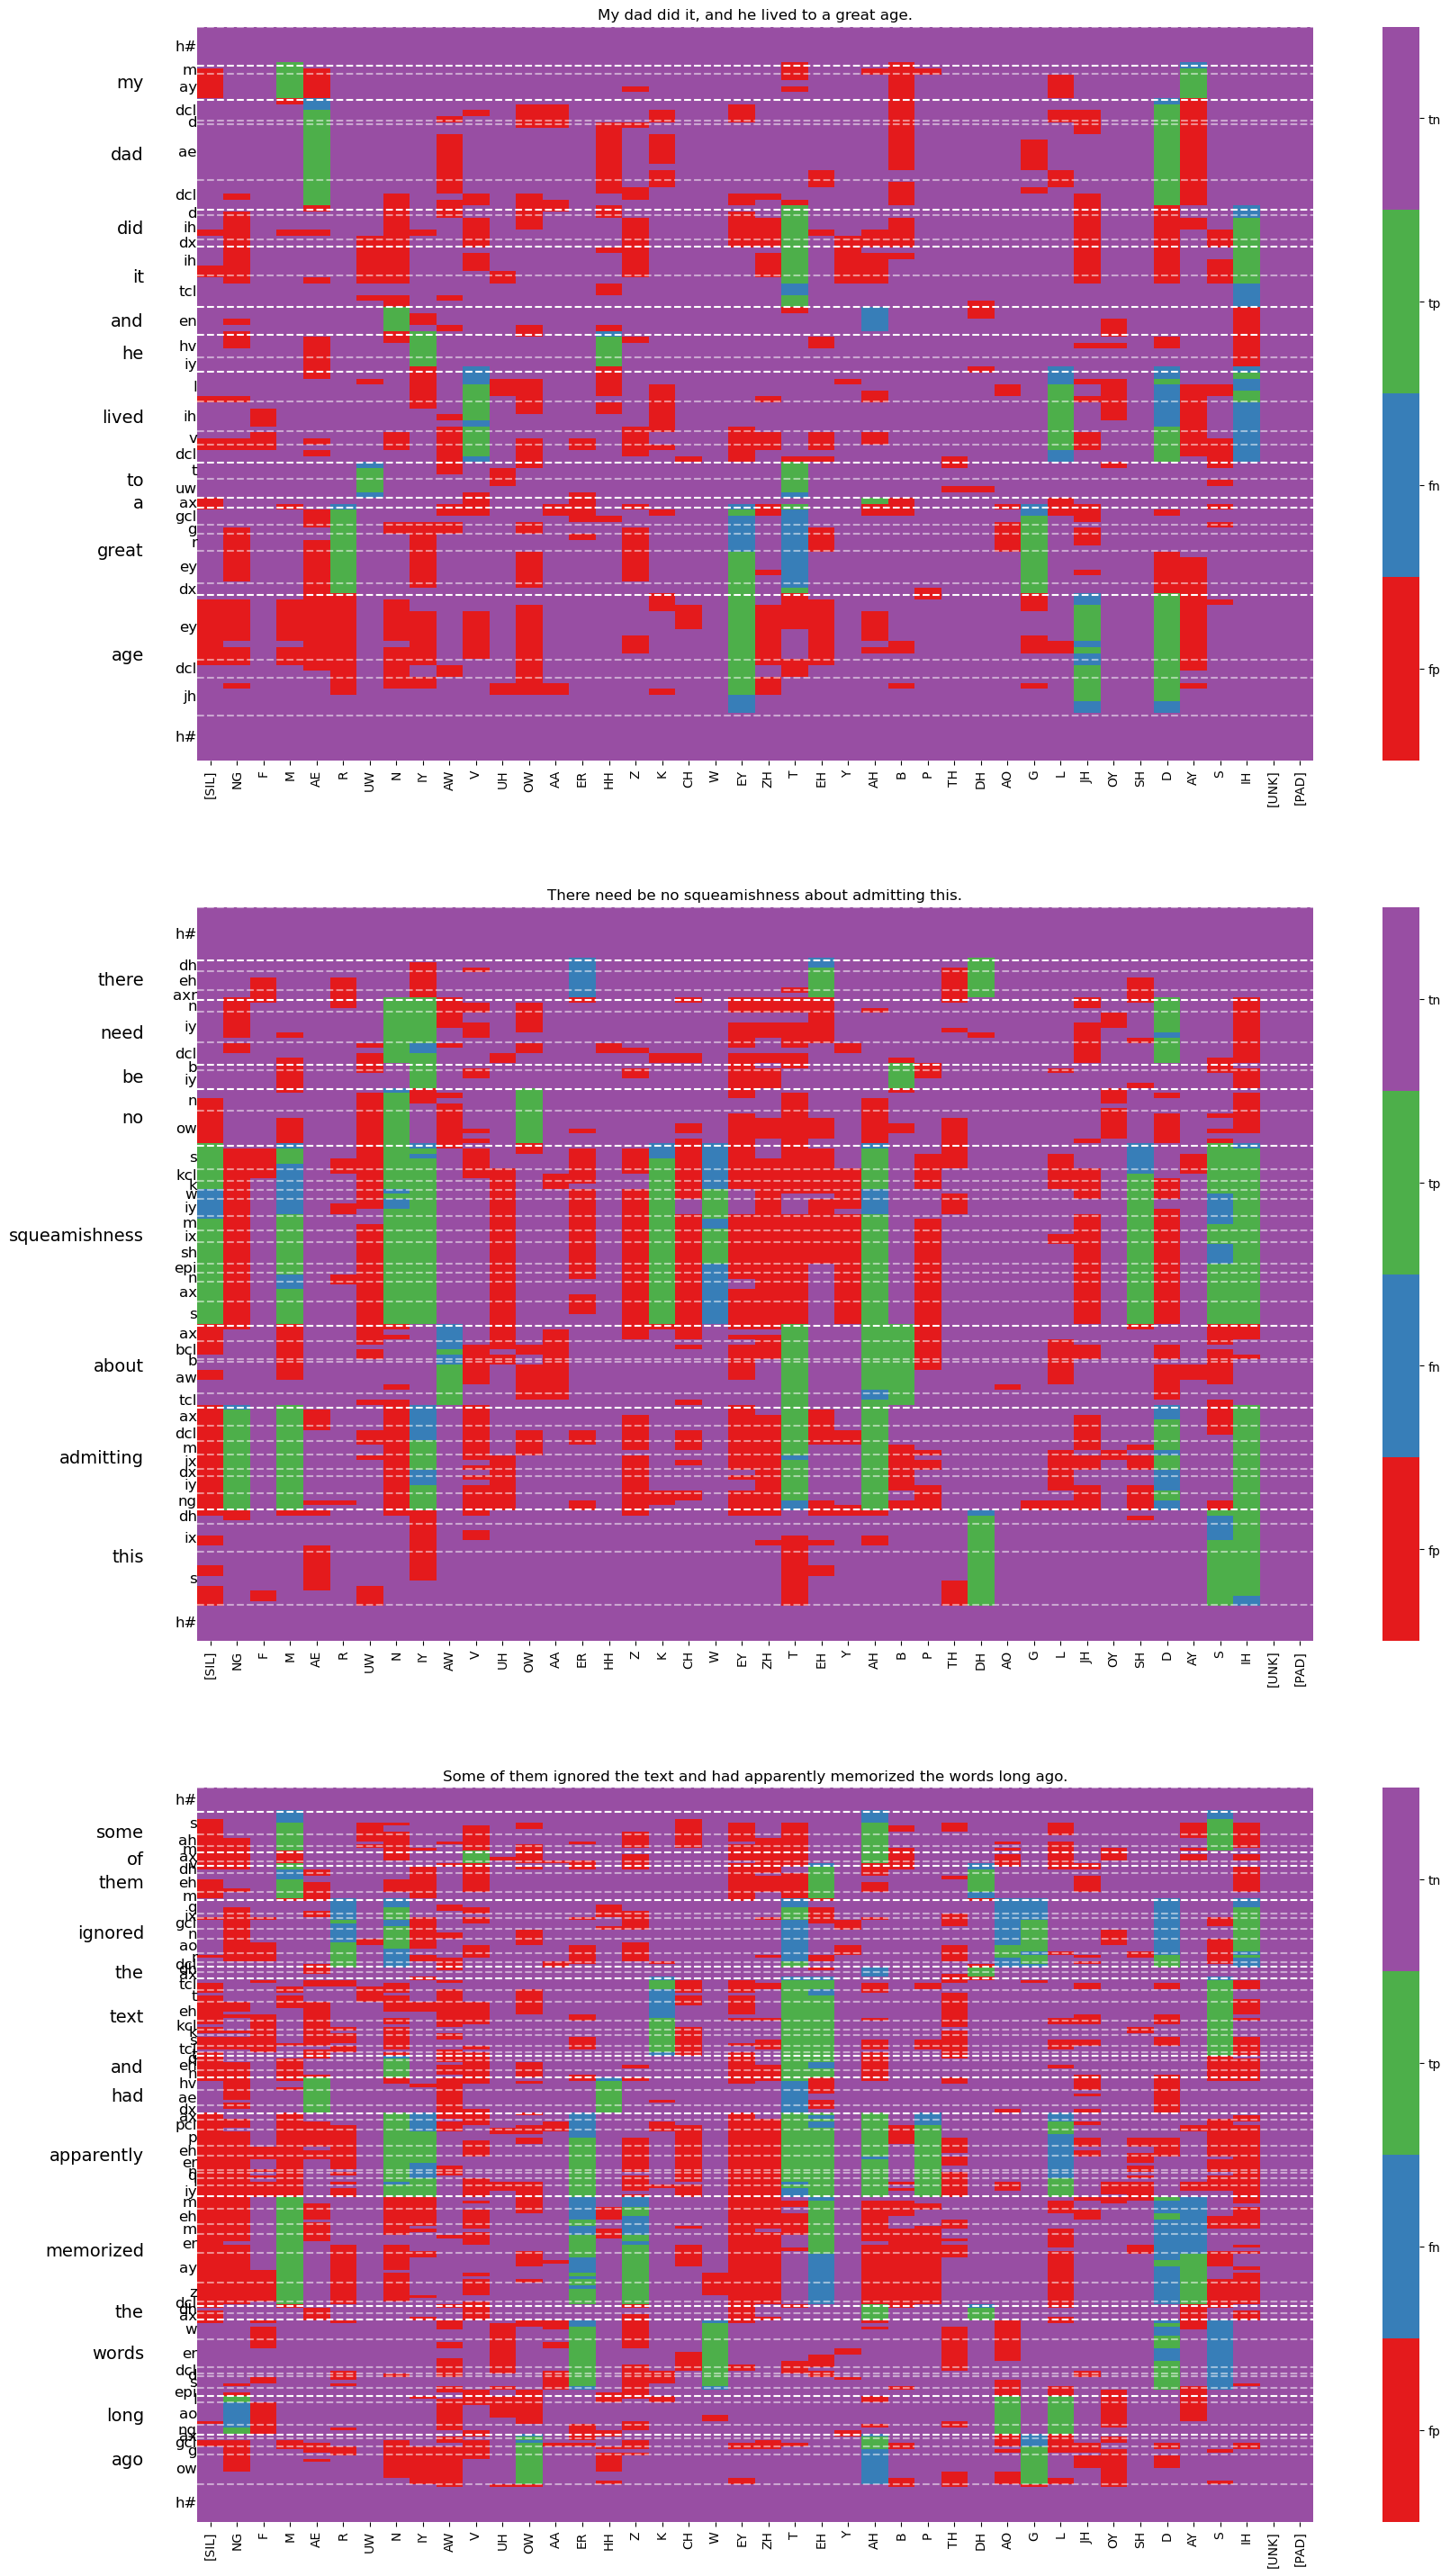

In [19]:
# viz labels
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 12 * n_to_plot))
# Use same plot_idxs as above
# plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    data = np.zeros_like(item["correct"]).astype(int)
    data[np.array(item["fp"])] = 1
    data[np.array(item["fn"])] = 2
    data[np.array(item["tp"])] = 3
    data[np.array(item["tn"])] = 4
    color_labels = ["fp", "fn", "tp", "tn"]

    # result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    result = pd.DataFrame(data[:num_item_frames], columns=viz_columns)
    sns.heatmap(result, ax=ax, cmap=sns.color_palette("Set1", 4))
    ax.set_title(item["text"])
    ax.set_yticks([])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
    colorbar.set_ticklabels(color_labels) 

    word_detail = item["word_detail"]
    word_starts = set()
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio
        word_starts.add(start)

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(-2, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    for i, (start, stop, phon) in enumerate(zip(item["phonetic_detail"]["start"], item["phonetic_detail"]["stop"], item["phonetic_detail"]["utterance"])):
        start = start * compression_ratio
        stop = stop * compression_ratio

        if start not in word_starts:
            ax.axhline(start, color="white", linestyle="--", alpha=0.5)
        
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, phon, ha="right", va="center", fontsize=12)